# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety

import codecs
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import math
import re
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [2]:
import nltk
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('stopwords')


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


False

In [3]:
# definiujemy potrzebne zmienne

nltk.download('stopwords')
PATH = './MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


In [4]:
# wczytujemy metadane artykułów

def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }

def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}

news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [5]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history

def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)

users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [6]:
# normalizujemy teksty na potrzeby dalszego przetwarzania

def preprocess_text(text):
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    text = re.sub(r'\s+', ' ', text)
    # usuwamy znaki interpunkcyjne
    text = re.sub(f'[{re.escape(punctuation)}]', '', text)
    # usuwamy wszystkie liczby
    text = re.sub(r'\d+', '', text)
    # podmieniamy wszystkie wielkie litery
    text = text.lower()
    # dzielimy na tokeny
    tokens = text.split()
    # usuwamy stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]
    return tokens   

def stem_texts(corpus):
    stemmer = SnowballStemmer('english')
    return [[stemmer.stem(word) for word in preprocess_text(text)] for text in corpus]

texts = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts = stem_texts(texts)

In [7]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think realli good team team realli special good thing group close brian schmetzer


In [8]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus):
    # generujemy posortowana alfabetycznie liste wszystkich slow (tokenow)
    words = set()
    for text in corpus:
        words.update(text)
    return sorted(words)

wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

41849


In [9]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz

def get_document_frequencies(corpus, wordlist):
    # return {word -> count}
    document_frequency = defaultdict(int)
    for word in wordlist:
        for text in corpus:
            if word in text:
                document_frequency[word] += 1
                continue
    return document_frequency

document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [10]:
# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie

def get_term_frequencies(corpus, news_indices):
    # return {news_id -> {word -> count}}
    return {news_id: {word: text.count(word) for word in text} for news_id, text in zip(news_indices, corpus)}

term_frequency = get_term_frequencies(stemmed_texts, news_indices)

In [11]:
# sprawdzmy wyniki

term_frequency[news_ids[2]]

{'think': 1,
 'realli': 2,
 'good': 2,
 'team': 2,
 'special': 1,
 'thing': 1,
 'group': 1,
 'close': 1,
 'brian': 1,
 'schmetzer': 1}

In [12]:
# obliczamy metryke tf_idf

def calculate_tf_idf(term_frequency, document_frequency, corpus_size):
    # return {news_id -> {word -> tf_idf}}
    return {news_id: {word: tf * math.log(corpus_size / df) for word, tf in tf_dict.items()} for news_id, tf_dict in term_frequency.items() for word, df in document_frequency.items() if word in tf_dict}

tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [13]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

{'think': 4.360459856758821,
 'realli': 8.720919713517642,
 'good': 8.720919713517642,
 'team': 8.720919713517642,
 'special': 4.360459856758821,
 'thing': 4.360459856758821,
 'group': 4.360459856758821,
 'close': 4.360459856758821,
 'brian': 4.360459856758821,
 'schmetzer': 4.360459856758821}

## Część 3. - Podobieństwo tekstów

In [40]:
# obliczmy odleglosc miedzy dwoma artykulami
# przetestuj rozne metryki odleglosci i wybierz najlepsza

def calculate_vector_distance(
    v1: dict[str, float],
    v2: dict[str, float],
    metric:str ='euclidean'
) -> float:
    if metric == 'euclidean':
        return math.sqrt(sum([(v1[word] - v2[word]) ** 2 for word in v1 if word in v2]))
    elif metric == 'cosine':
        return sum([v1[word] * v2[word] for word in v1 if word in v2]) / (math.sqrt(sum([v1[word] ** 2 for word in v1])) * math.sqrt(sum([v2[word] ** 2 for word in v2])))

    raise ValueError(f'Unknown metric: {metric}')


def calculate_distance(tf_idf, id1, id2, metric='euclidean'):
    if id2 not in tf_idf or id1 not in tf_idf:
        return 0
    if metric == 'euclidean':
        return math.sqrt(sum([(tf_idf[id1][word] - tf_idf[id2][word]) ** 2 for word in tf_idf[id1] if word in tf_idf[id2]]))
    elif metric == 'cosine':
        return sum([tf_idf[id1][word] * tf_idf[id2][word] for word in tf_idf[id1] if word in tf_idf[id2]]) / (math.sqrt(sum([tf_idf[id1][word] ** 2 for word in tf_idf[id1]])) * math.sqrt(sum([tf_idf[id2][word] ** 2 for word in tf_idf[id2]])))

calculate_distance(tf_idf, news_ids[2], news_ids[1])

2.1241753788764317

In [15]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id, corpus):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')

print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [16]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego

def get_k_most_similar_news(tf_idf, n_id, k):
    distances = [(calculate_distance(tf_idf, n_id, n_id2, 'cosine'), n_id2) for n_id2 in news_ids if n_id != n_id2]
    distances.sort(key=lambda x: x[0], reverse=True)
    return [x[1] for x in distances[:k]]


def print_k_most_similar_news(tf_idf, n_id, k, corpus):
    similar = get_k_most_similar_news(tf_idf, n_id, k)
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')
    for s_id in similar:
       print_news_entry(s_id, corpus)

print_k_most_similar_news(tf_idf, news_ids[42337], 5, news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [17]:
def calculate_average_vector(tf_idf, news_ids: list[str]) -> dict[str, float]:
    # Initialize empty dictionary for the average vector
    avg_vector = defaultdict(float)
    
    # Only process news_ids that exist in tf_idf
    valid_news_ids = [nid for nid in news_ids if nid in tf_idf]
    if not valid_news_ids:
        return {}
    
    # For each news article
    for news_id in valid_news_ids:
        # Add its tf-idf values to the average vector
        for word, value in tf_idf[news_id].items():
            avg_vector[word] += value
    
    # Divide by number of articles to get average
    for word in avg_vector:
        avg_vector[word] /= len(valid_news_ids)
    
    return dict(avg_vector)

def calculate_users_vectors(tf_idf, users_history) -> dict[str, dict]:
    return {user_id: calculate_average_vector(tf_idf, history) 
            for user_id, history in users_history.items()}

user_vectors = calculate_users_vectors(tf_idf, users_history)

In [18]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted([(k,v) for k,v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('fire', 2.556878320136654), ('counti', 1.126964330561626), ('acr', 1.0607217678357812), ('california', 1.057274856548666), ('hous', 0.9608745016730948), ('impeach', 0.9608745016730948), ('plane', 0.9463183534254479), ('report', 0.9068101108210661), ('found', 0.9034958080212727), ('maria', 0.8716365019018982), ('ventura', 0.8716365019018982), ('land', 0.8617871143802064), ('accord', 0.794299766800661), ('mcconnel', 0.7423823409262291), ('consum', 0.690580286928323), ('around', 0.686273302898798), ('state', 0.6699864210481787), ('contain', 0.6639305035958452), ('help', 0.65919888469176), ('blood', 0.65919888469176), ('pressur', 0.65919888469176), ('food', 0.65919888469176), ('first', 0.6498909429035783), ('santa', 0.6459487326409673), ('paula', 0.6459487326409673), ('senat', 0.6405830011153966), ('monday', 0.6377572801590973), ('sinc', 0.6331507531353169), ('final', 0.6331507531353169), ('complaint', 0.6257185051552372), ('game', 0.6257185051552372), ('board', 0.6257185051552372), ('li

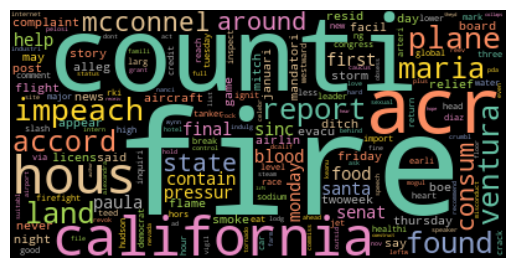

In [19]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

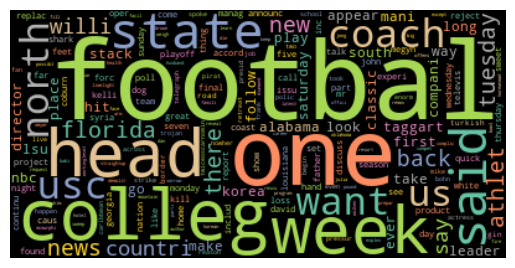

id: N9721
	title: 50 Foods You Should Never Eat, According to Health Experts
	text: This is so depressing.
id: N64498
	title: PGA Tour winners
	text: A gallery of recent winners on the PGA Tour.
id: N20139
	title: 40+ Stuffed Pasta Recipes You'll Want To Make Every Night
	text: Stuff yourself.
id: N27214
	title: 19 Super Delicious Fall Soups Made From Scratch to Try Now (Including Pumpkin!)
	text: Slurp away!
id: N64593
	title: An avocado a day could lower your 'bad' cholesterol levels and reduce your risk of heart disease
	text: "Bad" cholesterol means LDL (low-density lipoprotein), and having too much can clot arteries and lead to heart problems.


In [43]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal

def recommend(tf_idf, user_id, news, users_history, k):
    user_vector = user_vectors[user_id]
    user_history = users_history[user_id]
    nonuser_news_ids = filter(
        lambda n_id: n_id not in user_history, news.keys()
    )
    recommendation = {}  # [id_artykułu: dystans]

    for news_id in nonuser_news_ids:
        if news_id in user_history or news_id not in tf_idf:
            continue
        recommendation[news_id] = calculate_vector_distance(user_vector, tf_idf[news_id])

    k_recommended_news_ids: list[str] = sorted(
        [news_id for news_id in recommendation.keys()],
        key=lambda n_id: recommendation[n_id]
    )[:k]

    return k_recommended_news_ids

def __show_news(news_ids: list[str]) -> None:
    for news_id in news_ids:
        print_news_entry(news_id, news)

# dla wybranego uzytkownika, korzystajac z juz zaimplementowanych funkcji,
#   pokaz jego historie, profil (wordcloud) i rekomendacje

test_user = test_users[3]
plot_vector(user_vectors[test_user])
__show_news(recommend(tf_idf, test_user, news, users_history, 5))


## Część 6. - Ocena jakości

In [31]:
# jaccard index to metryka podobienstwa zbiorow, lekko ja zmodyfikujemy
# przeciecie wektorow to minimum po kazdej wspolrzednej
# unia wektorow to maksimum po kazdej wspolrzednej
# jaccard index to iloraz sum tych dwoch wartosci

def jaccard(v1, v2):
    intersection = {word: min(v1[word], v2[word]) for word in v1 if word in v2}
    union = {word: max(v1[word], v2[word]) for word in v1}
    return sum(intersection.values()) / sum(union.values())


In [41]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa

